## **Force Response Pattern**

### **Derived Equation Set**

**Linearized Barotropic Model**

We begin with the **linearized divergent barotropic model**, which describes a single layer of incompressible fluid with homogeneous density and a free surface under hydrostatic balance:

$$\frac{\partial u}{\partial t}-fv=-\frac{\partial \phi}{\partial x}$$
$$\frac{\partial v}{\partial t}+fu=-\frac{\partial \phi}{\partial y}$$
$$\frac{\partial \phi}{\partial t}+c^2(\nabla \cdot u)=0$$

**Beta-Plane Approximation and Non-Dimensionalization**

To simplify the system, we apply the **beta-plane approximation** and perform **non-dimensionalization** (following Matsuno 1966 and Gill 1980). After these transformations, the equations become:

$$\frac{\partial u}{\partial t}-\frac{1}{2}yv=-\frac{\partial \phi}{\partial x}$$
$$\frac{\partial v}{\partial t}+\frac{1}{2}yu=-\frac{\partial \phi}{\partial y}$$
$$\frac{\partial \phi}{\partial t}+\nabla \cdot u=0$$

**Steady-State System with Forcing and Damping**

To analyze the system's response to steady external forcing, we introduce:
- a external forcing term $Q$,
- a linear damping process with damping coefficient $\epsilon$,
- and assume **steady state** (i.e., $\partial / \partial{t} = 0$)

The resulting steady-state equations are:

$$-\frac{1}{2}yv=-\frac{\partial \phi}{\partial x} - \epsilon{u}$$
$$\frac{1}{2}yu=-\frac{\partial \phi}{\partial y}- \epsilon{v}$$
$$\nabla \cdot u=Q- \epsilon{\phi}$$

**Reduction to a Single Equation**

Eliminating $u$, $\phi$, and expressing the system  in terms of the unknown variable $v$, and known quantities $Q$,$\epsilon$,$x$,$y$ (known), we obtain the following second-order PDE:
$$\epsilon^3v+\frac{1}{4}\epsilon y^2v-\epsilon \frac{\partial^2 v}{\partial x^2}-\epsilon \frac{\partial^2 v}{\partial y^2}-\frac{1}{2}\frac{\partial v}{\partial x} = \epsilon \frac{\partial Q}{\partial y}-\frac{1}{2}y\frac{\partial Q}{\partial x}$$

### **Numerical Discretization Approaches**

**Approach 1: Finite Difference in Both $x$ and $y$ (Not Applied)** 

Using finite difference matrices to approximate spatial derivatives in both $x$ and $y$ directions, the PDE becomes:

$$D_y V + V D_x = F$$

This is a **Sylvester equation** of the form $AX + XB = Q$, which requires specialized numerical techniques to solve. Due to its complexity, we do **not** pursue this method further in this note.


**Approach 2: FFT in $x$, FDM in $y$ (Applied)**

Instead, we apply the Fast Fourier Transform (FFT) in the $x$-direction. Denoting the Fourier-transformed variables with a hat (e.g., $\hat{v}$), the PDE becomes:

$$\epsilon^3 \hat{v}+\frac{1}{4}\epsilon y^2 \hat{v}+\epsilon k^2\hat{v}-\epsilon \frac{\partial^2 \hat{v}}{\partial y^2}-\frac{1}{2}ik\hat{v} = \epsilon \frac{\partial \hat{Q}}{\partial y}-\frac{1}{2}yik\hat{Q}$$

Next, we approximate the $y$-derivatives using finite difference matrices. The resulting matrix equation is:

$$\left( \epsilon^3 I \right) \hat{v} + \left( \frac{1}{4} \epsilon Y^2 \right) \hat{v} + \left( \epsilon I \right) \hat{v} K^2 - \left( \epsilon D^{(2)} \right) \hat{v} - \left( \frac{1}{2} I \right) \hat{v} K = \left( \epsilon D^{(1)} \right) \hat{Q} - \left( \frac{1}{2} Y \right) \hat{Q} K$$

Where:

- $\hat{v}, \hat{Q} \in \mathbb{C}^{N \times M}$
- $I \in \mathbb{R}^{N \times N}$
- $Y = \text{diag}(y) \in \mathbb{R}^{N \times N}$
- $Y^2 = \text{diag}(y^2) \in \mathbb{R}^{N \times N}$
- $K = \text{diag}(ik) \in \mathbb{C}^{M \times M}$
- $K^2 = \text{diag}(k^2) \in \mathbb{R}^{M \times M}$
- $D^{(1)}, D^{(2)} \in \mathbb{R}^{N \times N}$:first and second-order finite difference matrices in $y$

Note: $K$ and $K^2$ are diagonal and act on the right, the equation is again Sylvester-type. However, each column of $\hat{v}$ can now be solved **independently**, significantly simplifying the problem.

**Solving Each Fourier Mode**

For each wavenumber $k$ (i.e., each column $\hat{v}_k$), the equation reduces to a standard linear system:
For every k (every column), we have
$$\left( \epsilon^3 I \right) \hat{v}_k + \left( \frac{1}{4} \epsilon Y^2 \right) \hat{v}_k + \left( \epsilon k^2 I \right) \hat{v}_k - \left( \epsilon D^{(2)} \right) \hat{v}_k - \left( \frac{1}{2} ik I \right) \hat{v}_k = \left( \epsilon D^{(1)} \right) \hat{Q}_k - \left( \frac{1}{2} ik Y \right) \hat{Q}_k$$
$$\left( \epsilon^3 I + \frac{1}{4} \epsilon Y^2 + \epsilon k^2 I - \epsilon D^{(2)} -  \frac{1}{2} ik I\right) \hat{v}_k = \left( \epsilon D^{(1)} - \frac{1}{2} ik Y \right) \hat{Q}_k$$
$$\hat{v}_k = \left( \epsilon^3 I + \frac{1}{4} \epsilon Y^2 + \epsilon k^2 I - \epsilon D^{(2)} -  \frac{1}{2} ik I\right)^{-1} \left( \epsilon D^{(1)} - \frac{1}{2} ik Y \right) \hat{Q}_k$$

**Final Step: Inverse FFT**

Once all $\hat{v}_k$ are computed, we apply an inverse FFT along the $x$-direction (i.e., across each row of $\hat{v}_k$) to recover the physical-space solution $v(x,y)$.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
## Determin known quantities
Nx = 16 * 8
Ny = 9 * 8
Lx = 16 * 2
Ly = 9 * 2
x = np.linspace(-Lx / 2, Lx / 2, Nx, endpoint=False)
y = np.linspace(-Ly / 2, Ly / 2, Ny, endpoint=True)
yy, xx = np.meshgrid(y, x, indexing="ij")
dx = np.abs(x[1] - x[0])
dy = np.abs(y[1] - y[0])

eps = 1e-1

radius = 4
Q = 1
Q *= np.exp(-((xx / radius) ** 2))
Q *= np.exp(-((yy / radius) ** 2))
Q_fft = np.fft.fft(Q, axis=1, norm="ortho")
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi

In [8]:
## Preprare FDM matrix
diff_matrix_1st = -np.roll(np.eye(Ny), 1, axis=0) + np.roll(np.eye(Ny), -1, axis=0)
diff_matrix_1st[0, :] = 0
diff_matrix_1st[0, 0] = -1
diff_matrix_1st[0, 1] = 1
diff_matrix_1st[-1, :] = 0
diff_matrix_1st[-1, -2] = -1
diff_matrix_1st[-1, -1] = 1
diff_matrix_1st /= 2 * dy

diff_matrix_2nd = (
    -2 * np.eye(Ny) + np.roll(np.eye(Ny), 1, axis=0) + np.roll(np.eye(Ny), -1, axis=0)
)
diff_matrix_2nd[0, :] = 0
diff_matrix_2nd[0, 0] = -2
diff_matrix_2nd[0, 1] = 2
diff_matrix_2nd[-1, :] = 0
diff_matrix_2nd[-1, -2] = 2
diff_matrix_2nd[-1, -1] = -2
diff_matrix_2nd /= dy**2

In [9]:
## Solve v
U_fft = np.zeros_like(Q_fft, dtype=complex)
V_fft = np.zeros_like(Q_fft, dtype=complex)

for col in range(Nx):
    A = (
        eps**3 * np.eye(Ny)
        + 0.25 * eps * np.diag(y**2)
        + eps * k[col] ** 2 * np.eye(Ny)
        - eps * diff_matrix_2nd
        - 0.5 * 1j * k[col] * np.eye(Ny)
    )
    B = (eps * diff_matrix_1st - 0.5 * np.diag(y) * 1j * k[col]) @ Q_fft[:, col]
    V_fft[:, col] = np.linalg.inv(A) @ B

    C = 0.5 * eps * np.diag(y)
    D = 1j * k[col] * diff_matrix_1st
    E = 1j * k[col] * np.eye(Ny)
    F = (k[col] ** 2 + eps**2) * np.eye(Ny)
    U_fft[:, col] = np.linalg.inv(F) @ (
        C @ (V_fft[:, col]) + D @ (V_fft[:, col]) + E @ (Q_fft[:, col])
    )
U = np.fft.ifft(U_fft, axis=1, norm="ortho").real
V = np.fft.ifft(V_fft, axis=1, norm="ortho").real

Text(0, 0.5, 'y coordinate')

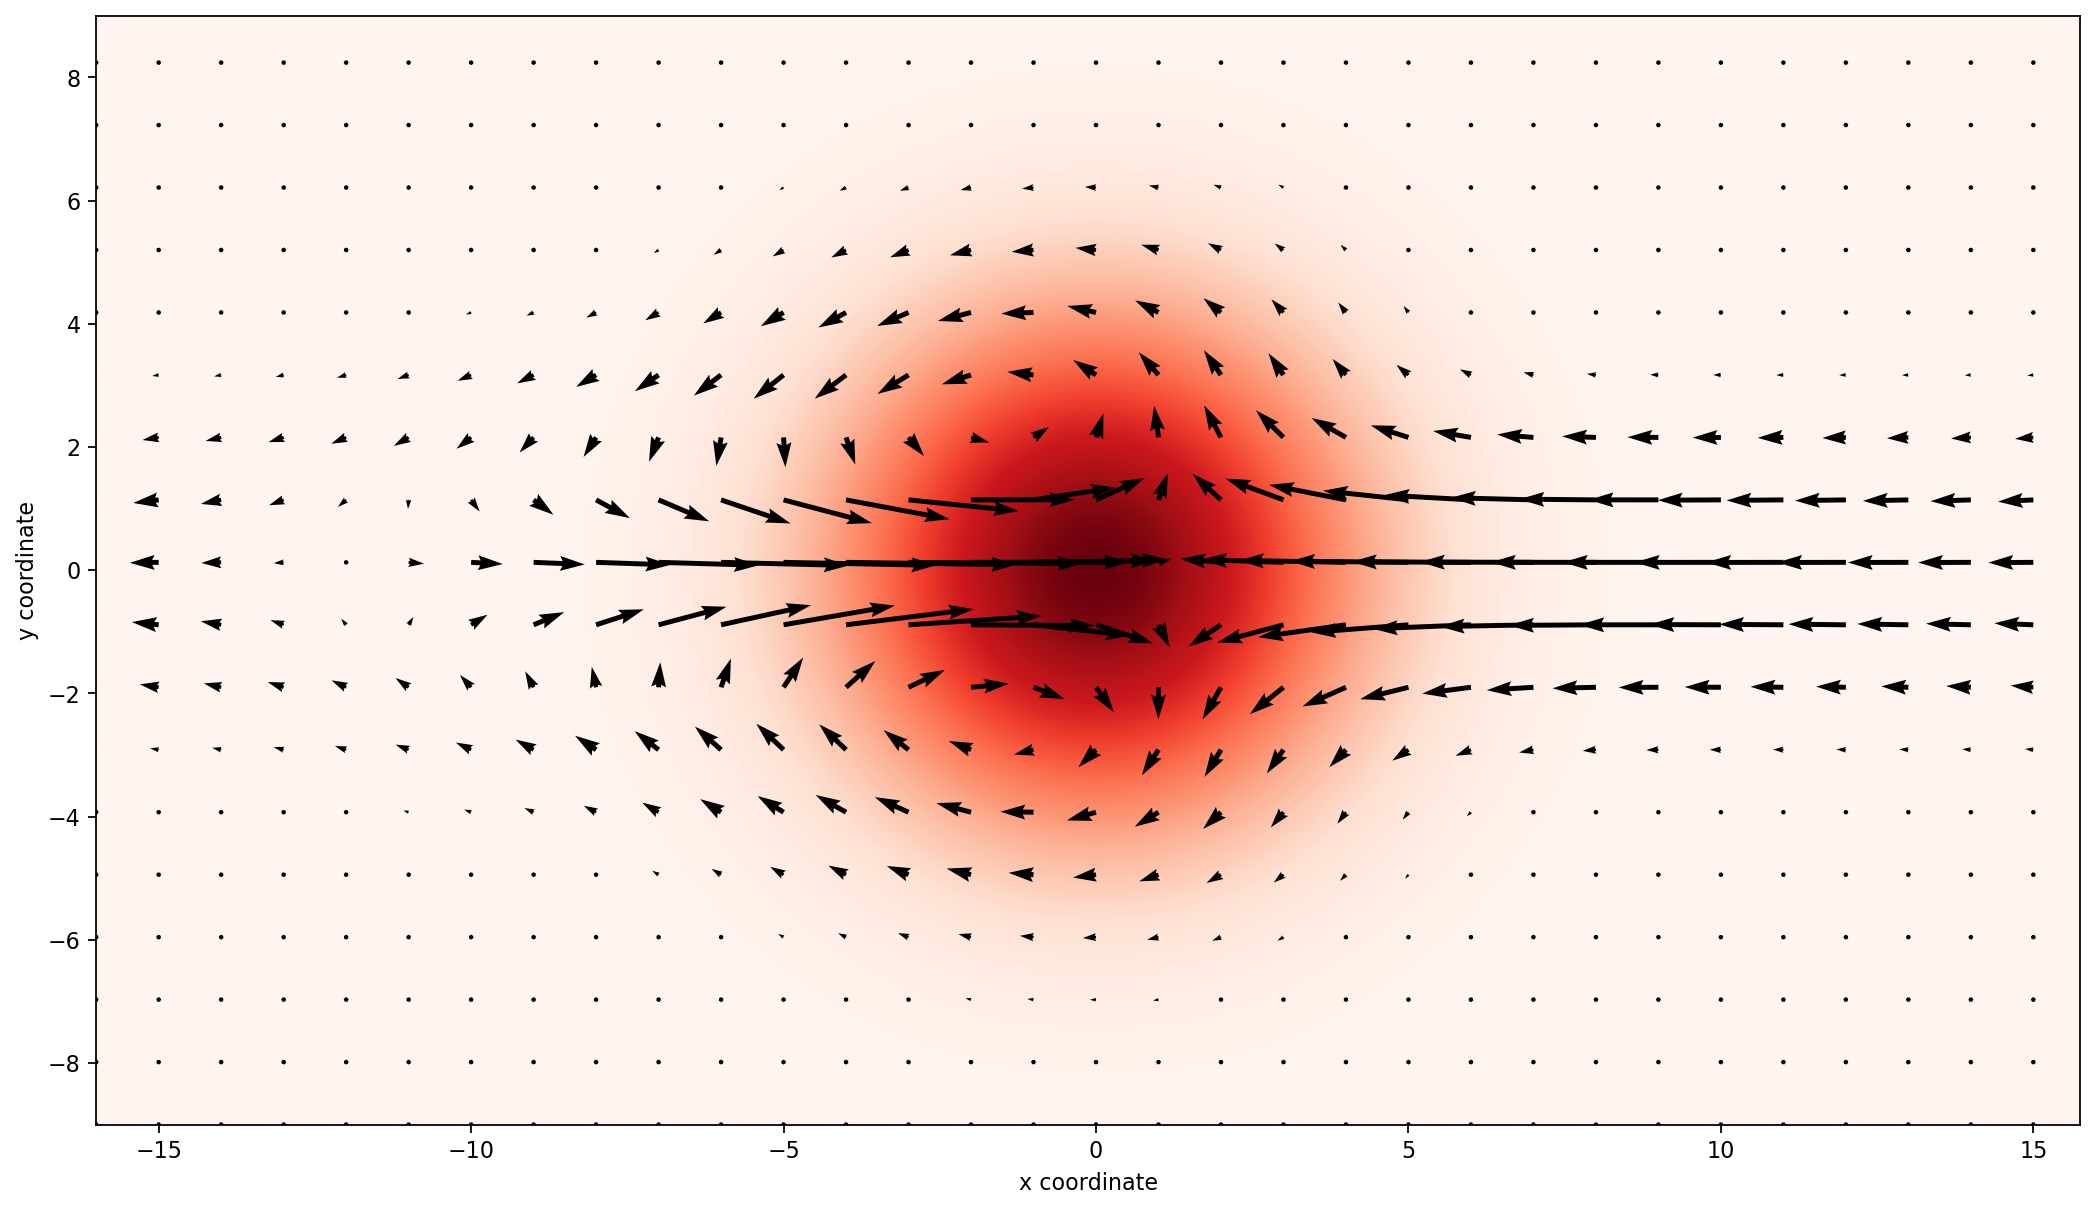

In [10]:
plt.figure(figsize=(16, 9), dpi=160)
plt.contourf(xx, yy, Q, levels=128, cmap="Reds")
plt.quiver(xx[::4, ::4], yy[::4, ::4], U[::4, ::4], V[::4, ::4], scale=40)

plt.xlabel("x coordinate")
plt.ylabel("y coordinate")